In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

import os
import seaborn as sns
from scipy.sparse import coo_matrix
import gc

from tqdm.notebook import tqdm
import time

tqdm.pandas(desc="Processing Data")

In [2]:
DOC_PATH = "/home/elionis/IR-Project/data/trec-robust04/doc_vectors"
QRELS_PATH = "/home/elionis/IR-Project/data/trec-robust04/robust04.qrels"
QUERY_PATH = "data/trec-robust04/query.tsv"
SAVE_TO_CACHE = True
COLLECT_ALL_SYMBOLS = True
CACHE_MEMORY_PATH = "/home/elionis/IR-Project/data/trec-robust04/cache_memory"
DELETE_ALL_CACHE = False
PRINT_TABLE = False
PRINT_LATEX = False
PRINT_PLOT = True
os.makedirs(CACHE_MEMORY_PATH, exist_ok=True)

In [3]:
if DELETE_ALL_CACHE:
    for file in os.listdir(CACHE_MEMORY_PATH):
        print("Removing:\t", CACHE_MEMORY_PATH + "/" + file)
        os.remove(CACHE_MEMORY_PATH + "/" + file)

In [4]:
if COLLECT_ALL_SYMBOLS:
    all_symbols = set()
    for files in os.listdir(DOC_PATH):
        df = pd.read_json(DOC_PATH + "/" + files, lines=True)
        df[["document", "segment"]] = df["id"].str.split("@@", expand=True)

        print("EXCTRACTING ALL SYMBOLS OF: \t", DOC_PATH + "/" + files)
        all_symbols = all_symbols.union(*df["vector"].apply(lambda x: x.keys()))

        del df
        gc.collect()  # force garbage collection

EXCTRACTING ALL SYMBOLS OF: 	 /home/elionis/IR-Project/data/trec-robust04/doc_vectors/part41
EXCTRACTING ALL SYMBOLS OF: 	 /home/elionis/IR-Project/data/trec-robust04/doc_vectors/part28
EXCTRACTING ALL SYMBOLS OF: 	 /home/elionis/IR-Project/data/trec-robust04/doc_vectors/part45
EXCTRACTING ALL SYMBOLS OF: 	 /home/elionis/IR-Project/data/trec-robust04/doc_vectors/part23
EXCTRACTING ALL SYMBOLS OF: 	 /home/elionis/IR-Project/data/trec-robust04/doc_vectors/part40
EXCTRACTING ALL SYMBOLS OF: 	 /home/elionis/IR-Project/data/trec-robust04/doc_vectors/part27
EXCTRACTING ALL SYMBOLS OF: 	 /home/elionis/IR-Project/data/trec-robust04/doc_vectors/part58
EXCTRACTING ALL SYMBOLS OF: 	 /home/elionis/IR-Project/data/trec-robust04/doc_vectors/part22
EXCTRACTING ALL SYMBOLS OF: 	 /home/elionis/IR-Project/data/trec-robust04/doc_vectors/part09
EXCTRACTING ALL SYMBOLS OF: 	 /home/elionis/IR-Project/data/trec-robust04/doc_vectors/part04
EXCTRACTING ALL SYMBOLS OF: 	 /home/elionis/IR-Project/data/trec-robus

In [5]:
if SAVE_TO_CACHE or os.listdir(CACHE_MEMORY_PATH) == []:
    for files in os.listdir(DOC_PATH):
        print("STARTING\t", DOC_PATH + "/" + files)
        if files + ".pkl" in os.listdir(CACHE_MEMORY_PATH):
            print(f"skipping {CACHE_MEMORY_PATH}/{files}.pkl file as it already exits")
            continue
        print("READING: \t", DOC_PATH + "/" + files)
        df = pd.read_json(DOC_PATH + "/" + files, lines=True)
        df[["document", "segment"]] = df["id"].str.split("@@", expand=True)

        # Step 1: Define a function that converts JSON sparse vector to sparse matrix
        def json_to_sparse_vector(sparse_json, all_symbols):
            # Create index mapping from symbols to indices
            index_mapping = {symbol: idx for idx, symbol in enumerate(all_symbols)}

            # Convert sparse_json to indices and values
            indices = [index_mapping[symbol] for symbol in sparse_json.keys()]
            values = [sparse_json[symbol] for symbol in sparse_json.keys()]

            # Create a sparse vector (COO format) for this row
            sparse_vector = coo_matrix(
                (values, (np.zeros(len(indices)), indices)), shape=(1, len(all_symbols))
            )

            # Convert to CSR for efficiency
            return sparse_vector.tocsr()

        print("EXCTRACTING SPARSE VECTORS OF: \t", DOC_PATH + "/" + files)
        df["sparse_matrix"] = df["vector"].apply(
            lambda x: json_to_sparse_vector(x, all_symbols)
        )

        print("SAVING: \t", DOC_PATH + "/" + files + ".pkl")
        df.to_pickle(CACHE_MEMORY_PATH + "/" + files + ".pkl")

        del df
        gc.collect()  # force garbage collection
        print("FINISHED WITH: \t", DOC_PATH + "/" + files)

STARTING	 /home/elionis/IR-Project/data/trec-robust04/doc_vectors/part41
skipping /home/elionis/IR-Project/data/trec-robust04/cache_memory/part41.pkl file as it already exits
STARTING	 /home/elionis/IR-Project/data/trec-robust04/doc_vectors/part28
skipping /home/elionis/IR-Project/data/trec-robust04/cache_memory/part28.pkl file as it already exits
STARTING	 /home/elionis/IR-Project/data/trec-robust04/doc_vectors/part45
skipping /home/elionis/IR-Project/data/trec-robust04/cache_memory/part45.pkl file as it already exits
STARTING	 /home/elionis/IR-Project/data/trec-robust04/doc_vectors/part23
skipping /home/elionis/IR-Project/data/trec-robust04/cache_memory/part23.pkl file as it already exits
STARTING	 /home/elionis/IR-Project/data/trec-robust04/doc_vectors/part40
skipping /home/elionis/IR-Project/data/trec-robust04/cache_memory/part40.pkl file as it already exits
STARTING	 /home/elionis/IR-Project/data/trec-robust04/doc_vectors/part27
skipping /home/elionis/IR-Project/data/trec-robust04

In [6]:
THE_MAIN_SEGMENT = None
THE_OTHER_SEGMENT = None
FUNCTION_2_USE = None
CONSTANT_NUMBER = None


def compare(df, pair, function_2_use):
    x_pair, y_pair = pair
    global THE_MAIN_SEGMENT
    global THE_OTHER_SEGMENT
    global FUNCTION_2_USE

    THE_MAIN_SEGMENT = x_pair
    THE_OTHER_SEGMENT = y_pair
    FUNCTION_2_USE = function_2_use
    return df.groupby("document").apply(function_2_use, include_groups=False)


def function_main_vs_other(group_df):
    main_seg_score = group_df.loc[
        group_df["segment"] == str(THE_MAIN_SEGMENT), "sparse_matrix"
    ].values
    other_seg_score = group_df.loc[
        group_df["segment"] == THE_OTHER_SEGMENT, "sparse_matrix"
    ].values

    # Calculate MAE between the first segment score and the rest of the segments
    if (
        len(main_seg_score) > 0 and len(other_seg_score) > 0
    ):  # Ensure there are other segments to compare
        main_seg_array = main_seg_score[0].toarray()[0]
        other_seg_array = other_seg_score[0].toarray()[0]

        function_value = abs_error(main_seg_array, other_seg_array)

        return function_value
    else:
        return None


def abs_error(x, y):
    return np.sum(np.abs(x - y))


def create_plot(list_dfs, plot_in_bins=False, color=None, limit=None):
    colors = [
        "tab:red",
        "tab:blue",
        "tab:green",
        "orange",
    ]  # Define multiple colors for the dfs
    plt.rcParams.update({"font.size": 21})  # Set to your desired size
    plt.figure(figsize=(12, 8))  # Create a figure once to plot all dataframes

    for i, (df, pair) in enumerate(list_dfs):
        if color is not None:
            color_picked = colors[color % len(colors)]  # Specific color
        else:
            color_picked = colors[
                i % len(colors)
            ]  # Cycle through the color list if more dfs than colors

        if plot_in_bins:
            sr = df.dropna()

            # Create bins for score differences
            df = pd.cut(
                sr,
                bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                right=False,
            )

        frequency_table = df.value_counts()
        if PRINT_TABLE:
            print(f"Table (DataFrame {i+1}):\n", frequency_table)
        if PRINT_LATEX:
            print(f"Latex table (DataFrame {i+1}):\n", frequency_table.to_latex())

        if PRINT_PLOT:
            label = f"{str(pair)}: N({np.round(np.mean(frequency_table.index),0).astype(int)},{np.round(np.std(frequency_table.index),0).astype(int)})"
            if plot_in_bins:
                frequency_table.plot(
                    kind="bar",
                    edgecolor=color_picked,
                    facecolor="none",
                    alpha=0.7,
                    label=label,
                )
                plt.xticks(rotation=45)
            else:
                kwargs = dict(hist_kws={"alpha": 0.25}, kde_kws={"linewidth": 2.5})
                sns.distplot(df.dropna(), color=color_picked, label=label, **kwargs)

    # Label the plot
    plt.xlabel("Total terms that satisfy the condition")
    plt.ylabel("Frequency (Normalized)")
    plt.ylim(0, 0.005 if limit is None else limit)
    plt.grid()
    # Add the legend to the plot
    plt.legend()

    # plt.tight_layout()

    # Show the plot
    plt.show()

Total common btw 2 segs

READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part09.pkl
time took: 23.306737899780273
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part59.pkl
time took: 23.326300382614136
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part08.pkl
time took: 17.800872325897217
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part39.pkl
time took: 29.71289300918579
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part51.pkl
time took: 23.483527898788452
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part04.pkl
time took: 22.965260982513428
The results:
Total number of documents for (1, 2) pair is: 25102
Total number of documents for (1, 3) pair is: 12293
Total number of documents for (1, 4) pair is: 6432
Total number of documents for (1, 6) pair is: 2125


/scratch-local/elionis.8347547/ipykernel_851871/2827864768.py:92: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.dropna(), color=color_picked, label=label, **kwargs)
/scratch-local/elionis.8347547/ipykernel_851871/2827864768.py:92: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.dropna(), col

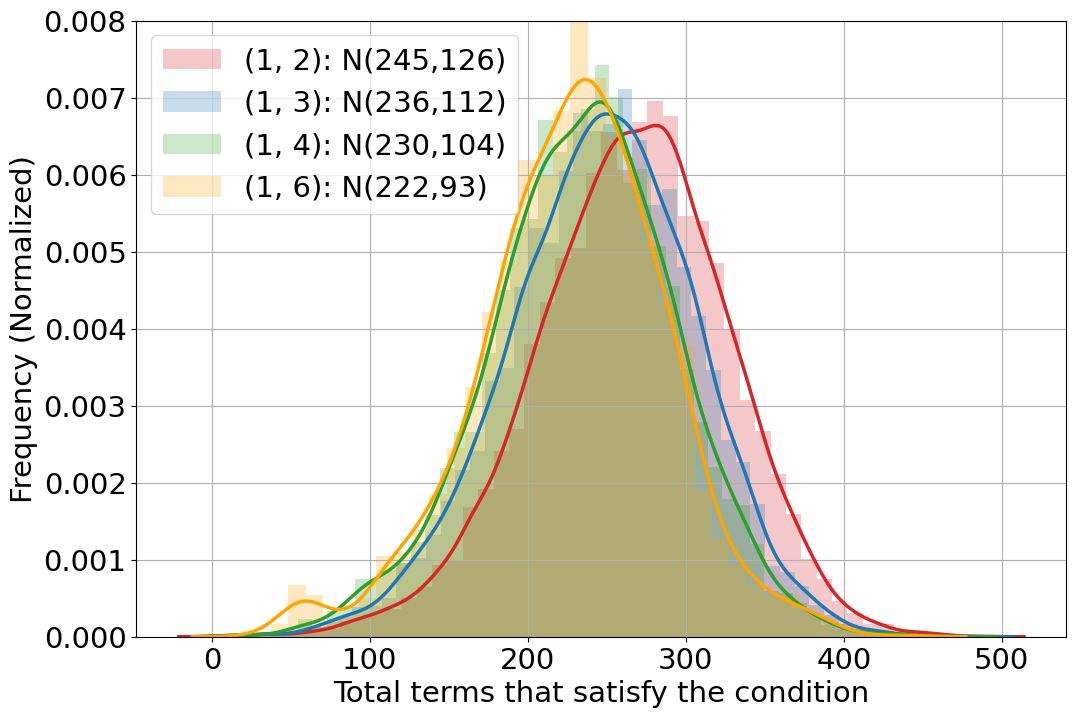

In [25]:
def function_main_vs_other_binary(group_df):
    main_seg_score = group_df.loc[
        group_df["segment"] == THE_MAIN_SEGMENT, "sparse_matrix"
    ].values
    other_seg_score = group_df.loc[
        group_df["segment"] == THE_OTHER_SEGMENT, "sparse_matrix"
    ].values

    # Calculate MAE between the first segment score and the rest of the segments
    if (
        len(main_seg_score) > 0 and len(other_seg_score) > 0
    ):  # Ensure there are other segments to compare
        main_seg_array = [main_seg_score[0].toarray()[0].astype(bool).astype(int)]
        # other_seg_array = other_seg_score[0].toarray()[0].astype(bool).astype(int)
        main_seg_array.extend(
            [i.toarray()[0].astype(bool).astype(int) for i in other_seg_score]
        )
        # function_value = abs_error(main_seg_array, other_seg_array)

        stacked = np.stack(main_seg_array)
        common_indexes = np.where(
            np.all(stacked == stacked[0], axis=0) & (stacked[0] != 0)
        )[0]
        

        function_value = common_indexes.shape[0]

        return function_value
    else:
        return None


CONSTANT_NUMBER = None
pairs = [(1, 2), (1, 3), (1, 4), (1, 6)]
folder_path = CACHE_MEMORY_PATH
results = [[] for _ in range(len(pairs))]
i = 0
total = len(os.listdir(folder_path))
how_many_files_to_see = 0.1
for files in os.listdir(folder_path):
    print("READING: \t", folder_path + "/" + files)
    s = time.time()

    df = pd.read_pickle(folder_path + "/" + files)
    df["segment"] = df["segment"].astype(int) + 1
    for index, pair in enumerate(pairs):
        result = compare(df, pair, function_main_vs_other_binary)
        results[index].append(result)
    del df
    gc.collect()
    i += 1
    print("time took:", time.time() - s)
    if i / total >= how_many_files_to_see:
        break

print("The results:")
all_dfs = []
for the_results, the_pair in list(zip(results, pairs)):
    all_dfs.append((pd.concat(the_results, ignore_index=True), the_pair))
    print(f"Total number of documents for {the_pair} pair is:", all_dfs[-1][0].count())
create_plot(all_dfs,limit=0.01)

Total common terms btw multiple segments, ie GLOBAL INFORMATION

READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part09.pkl
time took: 26.439293384552002
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part59.pkl
time took: 26.794267654418945
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part08.pkl
time took: 19.9933021068573
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part39.pkl
time took: 33.95213460922241
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part51.pkl
time took: 26.68456745147705
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part04.pkl
time took: 25.96674370765686
The results:
Total number of documents for (1, [2]) pair is: 25102
Total number of documents for (1, [2, 3]) pair is: 25102
Total number of documents for (1, [2, 3, 4]) pair is: 25102
Total number of documents for (1, [2, 3, 6]) pair is: 25102


/scratch-local/elionis.8347547/ipykernel_851871/2827864768.py:92: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.dropna(), color=color_picked, label=label, **kwargs)
/scratch-local/elionis.8347547/ipykernel_851871/2827864768.py:92: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.dropna(), col

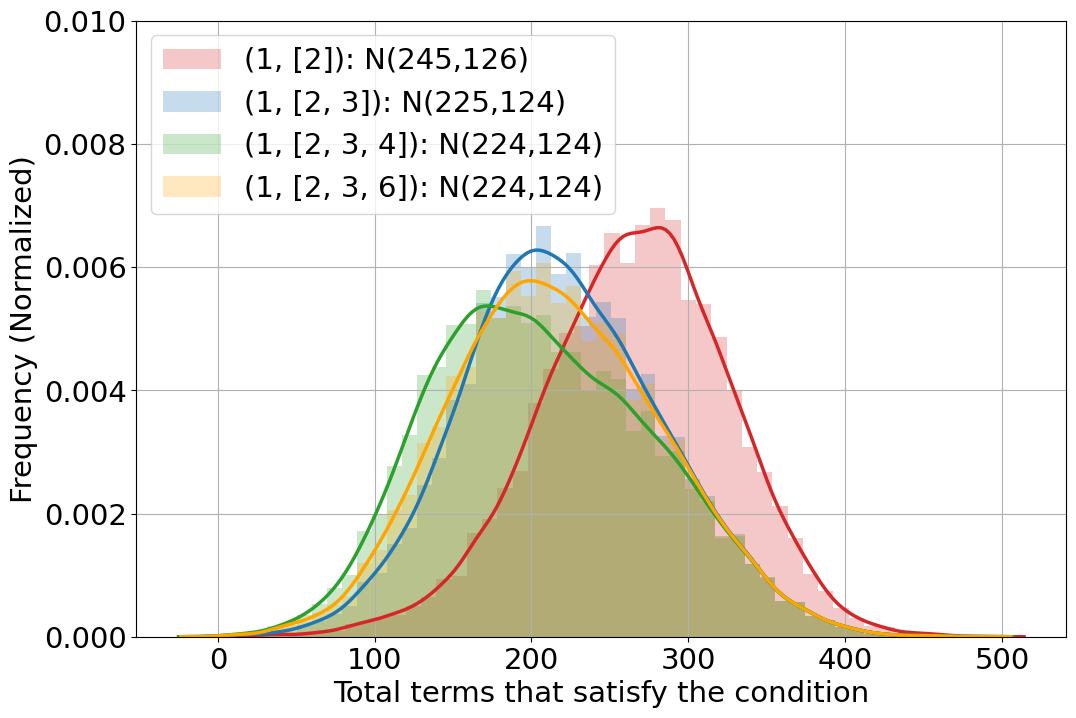

In [26]:
def function_common_terms_vs_others(group_df):
    global THE_MAIN_SEGMENT
    global epsilon
    # main_seg_score = group_df.loc[
    #     group_df["segment"].isin(THE_MAIN_SEGMENT), "sparse_matrix"
    # ].values

    main_seg_score = group_df.loc[
        group_df["segment"] == THE_MAIN_SEGMENT, "sparse_matrix"
    ].values
    other_seg_score = group_df.loc[
        group_df["segment"].isin(THE_OTHER_SEGMENT), "sparse_matrix"
    ].values

    # Calculate MAE between the first segment score and the rest of the segments
    if (
        len(main_seg_score) > 0 and len(other_seg_score) > 0
    ):  # Ensure there are other segments to compare
        main_seg_array = [main_seg_score[0].toarray()[0].astype(bool).astype(int)]
        # other_seg_array = other_seg_score[0].toarray()[0].astype(bool).astype(int)
        main_seg_array.extend(
            [i.toarray()[0].astype(bool).astype(int) for i in other_seg_score]
        )
        # main_seg_array = [
        #     i.toarray()[0].astype(bool).astype(int) for i in main_seg_score
        # ]
        # Stack the arrays for comparison
        stacked = np.stack(main_seg_array)
        common_indexes = np.where(
            np.all(stacked == stacked[0], axis=0) & (stacked[0] != 0)
        )[0]

        # Compute the function (e.g., MAE, or any custom function passed via FUNCTION_2_USE)
        function_value = common_indexes.shape[0]

        return function_value
    else:
        return None


pairs = [
    (1, [2]),
    (1, [2,3]),
    (1, [2,3,4]),
    (1, [2,3,6]),
]
folder_path = CACHE_MEMORY_PATH
results = [[] for _ in range(len(pairs))]
i = 0
total = len(os.listdir(folder_path))
how_many_files_to_see = 0.1
for files in os.listdir(folder_path):
    print("READING: \t", folder_path + "/" + files)
    s = time.time()

    df = pd.read_pickle(folder_path + "/" + files)
    df["segment"] = df["segment"].astype(int) + 1
    for index, pair in enumerate(pairs):
        result = compare(df, pair, function_common_terms_vs_others)
        results[index].append(result)
    del df
    gc.collect()
    i += 1
    print("time took:", time.time() - s)
    if i / total >= how_many_files_to_see:
        break

print("The results:")
all_dfs = []
for the_results, the_pair in list(zip(results, pairs)):
    # the_pair = [int(i) for i in the_pair[0]]
    # the_pair = tuple(the_pair)
    all_dfs.append((pd.concat(the_results, ignore_index=True), the_pair))
    print(f"Total number of documents for {the_pair} pair is:", all_dfs[-1][0].count())
create_plot(all_dfs,limit=0.01)

UNIQUE TERMS

READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part09.pkl


time took: 26.603415489196777
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part59.pkl
time took: 27.073475122451782
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part08.pkl
time took: 20.260986804962158
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part39.pkl
time took: 34.21412110328674
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part51.pkl
time took: 27.233341932296753
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part04.pkl
time took: 26.499919652938843
The results:
Total number of documents for (1, [2]) pair is: 25102
Total number of documents for (1, [2, 3]) pair is: 25102
Total number of documents for (1, [2, 3, 4]) pair is: 25102
Total number of documents for (1, [2, 3, 4, 6]) pair is: 25102


/scratch-local/elionis.8347547/ipykernel_851871/2827864768.py:92: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.dropna(), color=color_picked, label=label, **kwargs)
/scratch-local/elionis.8347547/ipykernel_851871/2827864768.py:92: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.dropna(), col

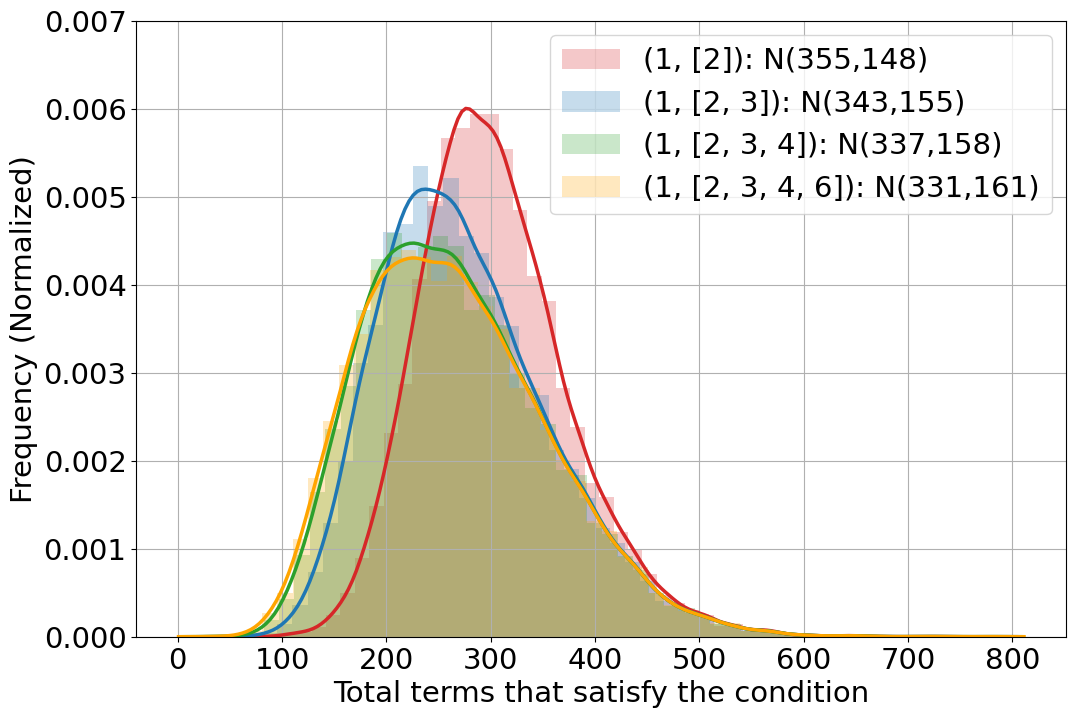

In [27]:
def function_common_terms_vs_others(group_df):
    global THE_MAIN_SEGMENT
    global THE_OTHER_SEGMENT
    main_seg_score = group_df.loc[
        group_df["segment"] == THE_MAIN_SEGMENT, "sparse_matrix"
    ].values
    other_seg_score = group_df.loc[
        group_df["segment"].isin(THE_OTHER_SEGMENT), "sparse_matrix"
    ].values

    # Calculate MAE between the first segment score and the rest of the segments
    if (
        len(main_seg_score) > 0 and len(other_seg_score) > 0
    ):  # Ensure there are other segments to compare
        main_seg_array = [
            i.toarray()[0].astype(bool).astype(int) for i in main_seg_score
        ]
        main_seg_array.extend(
            [i.toarray()[0].astype(bool).astype(int) for i in other_seg_score]
        )
        # Stack the arrays for comparison
        stacked = np.stack(main_seg_array)
        first_array = stacked[0]

        # Create a mask where the first array is non-zero
        non_zero_mask = first_array != 0

        # Check where first array has no common non-zero values with other arrays
        no_common_nonzero_mask = non_zero_mask & ~np.any(
            (stacked[1:] == first_array) & (stacked[1:] != 0), axis=0
        )

        function_value = no_common_nonzero_mask.sum()

        return function_value
    else:
        return None


pairs = [(1, [2]), (1, [2, 3]), (1, [2, 3, 4]), (1, [2, 3, 4, 6])]
folder_path = CACHE_MEMORY_PATH
results = [[] for _ in range(len(pairs))]
i = 0
total = len(os.listdir(folder_path))
how_many_files_to_see = 0.1
for files in os.listdir(folder_path):
    print("READING: \t", folder_path + "/" + files)
    s = time.time()

    df = pd.read_pickle(folder_path + "/" + files)
    df["segment"] = df["segment"].astype(int) + 1
    for index, pair in enumerate(pairs):
        result = compare(df, pair, function_common_terms_vs_others)
        results[index].append(result)
    del df
    gc.collect()
    i += 1
    print("time took:", time.time() - s)
    if i / total >= how_many_files_to_see:
        break

print("The results:")
all_dfs = []
for the_results, the_pair in list(zip(results, pairs)):
    all_dfs.append((pd.concat(the_results, ignore_index=True), the_pair))
    print(f"Total number of documents for {the_pair} pair is:", all_dfs[-1][0].count())
create_plot(all_dfs,limit=0.01)

INFLUENCE

In [7]:
def find_common_indxes_and_uncommon_indexes(group_df):
    global THE_MAIN_SEGMENT
    global THE_OTHER_SEGMENT
    main_seg_score = group_df.loc[
        group_df["segment"] == THE_MAIN_SEGMENT, "sparse_matrix"
    ].values
    other_seg_score = group_df.loc[
        group_df["segment"].isin(THE_OTHER_SEGMENT), "sparse_matrix"
    ].values

    # Calculate MAE between the first segment score and the rest of the segments
    if (
        len(main_seg_score) == 1 and len(other_seg_score) >= 2
    ):  # Ensure there are other segments to compare
        main_seg_array = [
            i.toarray()[0].astype(bool).astype(int) for i in main_seg_score
        ]
        main_seg_array.extend(
            [i.toarray()[0].astype(bool).astype(int) for i in other_seg_score]
        )
        # Stack the arrays for comparison
        stacked = np.stack(main_seg_array)
        first_array = stacked[0]

        # Create a mask where the first array is non-zero
        non_zero_mask = first_array != 0

        # Check where first array has no common non-zero values with other arrays
        common_indexes_with_1st_a_2nd_a_3rd = np.where(
            np.all(stacked == stacked[0], axis=0) & (stacked[0] != 0)
        )[0]

        common_indexes_with_1st_a_2nd = np.where(
            non_zero_mask
            & (stacked[0] == stacked[1])
            & ~np.any((stacked[1:] == first_array))
        )[0]
        common_indexes_with_1st_a_3rd = np.where(
            non_zero_mask
            & (stacked[0] == stacked[2])
            & ~np.any((stacked[1:] == first_array))
        )[0]

        common_indexes_with_2nd_a_3rd = np.where(
            non_zero_mask
            & (stacked[1] == stacked[2])
            & ~np.any((stacked[1:] == first_array))
        )[0]


        only_first = np.where(
            non_zero_mask & ~np.any((stacked[1:] == first_array), axis=0)
        )[0]

        return (
            only_first,
            common_indexes_with_1st_a_2nd,
            common_indexes_with_1st_a_3rd,
            common_indexes_with_2nd_a_3rd,
            common_indexes_with_1st_a_2nd_a_3rd,
        )
    else:
        return [], [], [], [], []


pairs = [(1, [2, 3])]
folder_path = CACHE_MEMORY_PATH
qrels = pd.read_csv(QRELS_PATH, sep=" ", header=None)
qrels = qrels.rename(columns={0: "query", 2: "document"})
qrels[qrels[3] == 1]
qrel_documents = qrels.document.to_list()

i = 0
total = len(os.listdir(folder_path))
how_many_files_to_see = 1
results = [[] for _ in range(len(pairs))]
for files in os.listdir(folder_path):
    print("READING: \t", folder_path + "/" + files)
    s = time.time()

    df = pd.read_pickle(folder_path + "/" + files)
    df["segment"] = df["segment"].astype(int) + 1
    df = df[df["document"].isin(qrel_documents)]
    df = df[
        df["segment"].isin(
            list(
                set(
                    [item for sublist in pairs for item in sublist[1]]
                    + [item[0] for item in pairs]
                )
            )
        )
    ]
    for index, pair in enumerate(pairs):
        values = compare(df, pair, find_common_indxes_and_uncommon_indexes)
        df_merged = pd.merge(df, values.reset_index(), on="document", how="left")
        result = pd.merge(df_merged, qrels, on="document", how="inner")
        results[index].append(result)

    i += 1
    print("time took:", time.time() - s)
    if i / total >= how_many_files_to_see:
        break

READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part09.pkl


time took: 4.648932933807373
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part59.pkl
time took: 5.512162208557129
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part08.pkl
time took: 4.808985471725464
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part39.pkl
time took: 5.664336204528809
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part51.pkl
time took: 5.445637464523315
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part04.pkl
time took: 5.026290416717529
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part28.pkl
time took: 5.634976863861084
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part29.pkl
time took: 5.193687438964844
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part44.pkl
time took: 5.537011384963989
READING: 	 /home/elionis/IR-Project/data/trec-robust04/cache_memory/part56.pkl
time took: 5.322273254394531

In [8]:
query = pd.read_csv(QUERY_PATH, sep="\t", header=None)
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary=all_symbols)

query = query.rename(columns={0: "query", 1: "vector"})


# Step 1: Define a function that converts JSON sparse vector to sparse matrix
def json_to_sparse_vector(vector, all_symbols):
    index_mapping = {symbol: idx for idx, symbol in enumerate(all_symbols)}

    # Step 2: Initialize lists to store the row indices, column indices, and data values
    row_indices = []
    col_indices = []
    data_values = []

    # Step 3: Populate the lists based on `index_mapping`
    for row_idx, doc in enumerate(vector.split(" ")):
        words = doc.split()
        for word in words:
            if word in index_mapping:  # Only consider words in the index mapping
                col_idx = index_mapping[word]
                row_indices.append(0)
                col_indices.append(col_idx)
                data_values.append(
                    1
                )  # Assuming term frequency of 1 for each occurrence

    # Step 4: Create the COO sparse matrix
    num_rows = len(vector.split(" "))
    num_cols = len(all_symbols)
    return coo_matrix(
        (data_values, (row_indices, col_indices)), shape=(num_rows, num_cols)
    )


query["sparse_matrix"] = query["vector"].apply(
    lambda x: json_to_sparse_vector(x, all_symbols)
)

In [9]:
merged_df = pd.merge(pd.concat(results[0]), query, on="query", how="inner")

In [10]:
def the_function(group_df):
    sparse_matrix_x = group_df.loc[group_df["segment"] == 1, "sparse_matrix_x"].values
    sparse_matrix_y = group_df.loc[group_df["segment"] == 1, "sparse_matrix_y"].values
    sparse_x = sparse_matrix_x[0].toarray()[0]
    sparse_y = sparse_matrix_y[0].toarray()[0]
    (
        only_first,
        common_indexes_with_1st_a_2nd,
        common_indexes_with_1st_a_3rd,
        common_indexes_with_2nd_a_3rd,
        common_indexes_with_1st_a_2nd_a_3rd,
    ) = group_df.loc[group_df["segment"] == 1, 0].values[0]

    if sparse_x.shape != sparse_y.shape:
        sparse_y = sparse_y[:-3]
        
    all_sum = (sparse_x * sparse_y).sum()

    only_first = (sparse_x[only_first] * sparse_y[only_first]).sum()
    common_indexes_with_1st_a_2nd = (
        sparse_x[common_indexes_with_1st_a_2nd]
        * sparse_y[common_indexes_with_1st_a_2nd]
    ).sum()
    common_indexes_with_1st_a_3rd = (
        sparse_x[common_indexes_with_1st_a_3rd]
        * sparse_y[common_indexes_with_1st_a_3rd]
    ).sum()
    common_indexes_with_2nd_a_3rd = (
        sparse_x[common_indexes_with_2nd_a_3rd]
        * sparse_y[common_indexes_with_2nd_a_3rd]
    ).sum()
    common_indexes_with_1st_a_2nd_a_3rd = (
        sparse_x[common_indexes_with_1st_a_2nd_a_3rd]
        * sparse_y[common_indexes_with_1st_a_2nd_a_3rd]
    ).sum()

    if all_sum != 0:
        return (
            all_sum,
            only_first,
            common_indexes_with_1st_a_2nd,
            common_indexes_with_1st_a_3rd,
            common_indexes_with_2nd_a_3rd,
            common_indexes_with_1st_a_2nd_a_3rd,
            only_first / all_sum,
            common_indexes_with_1st_a_2nd / all_sum,
            common_indexes_with_1st_a_3rd / all_sum,
            common_indexes_with_2nd_a_3rd / all_sum,
            common_indexes_with_1st_a_2nd_a_3rd / all_sum,
        )
    else:
        return 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0


result_of_merged_df = merged_df.groupby("document").apply(the_function)
df_tmp = result_of_merged_df.reset_index()
df_tmp[
    [
        "all_sum",
        "only_first",
        "first_and_second_sum",
        "first_and_third_sum",
        "second_and_third_sum",
        "common_indexes_with_1st_a_2nd_a_3rd",
        "only first segment terms",
        "first and second segment intesection terms",
        "first and third segment intesection terms",
        "second and third segment intesection terms",
        "global terms",
    ]
] = pd.DataFrame(df_tmp[0].tolist(), index=df_tmp.index)

/scratch-local/elionis.8370281/ipykernel_1786481/2621927279.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_of_merged_df = merged_df.groupby("document").apply(the_function)


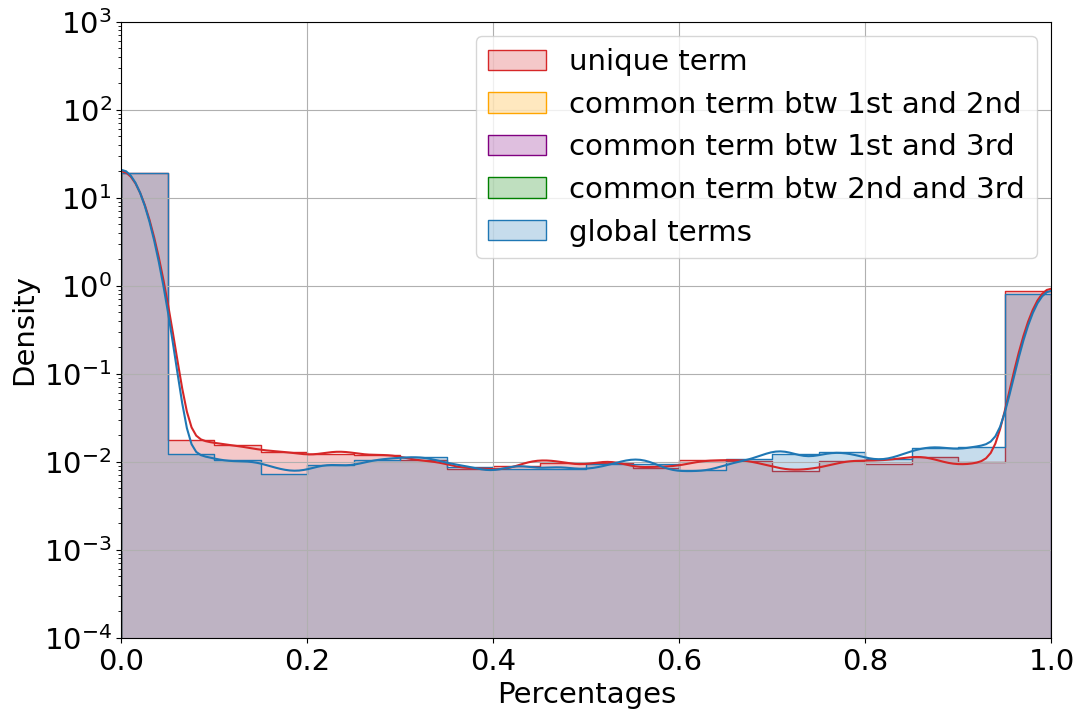

In [15]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

colors = ["tab:red","orange", "purple", "green", "tab:blue"]
kwargs = dict(hist_kws={"alpha": 0.25}, kde_kws={"linewidth": 2.5})

plt.rcParams.update({"font.size": 21})  # Set to your desired size

plt.figure(figsize=(12, 8))

label_mapping={
    "only first segment terms":"unique term",
    "first and second segment intesection terms":"common term btw 1st and 2nd",
    "first and third segment intesection terms":"common term btw 1st and 3rd",
    "second and third segment intesection terms":"common term btw 2nd and 3rd",
    "global terms": "global terms"
}
# Step 3: Create the main distribution plot
for i, column in enumerate(
    [
        "only first segment terms",
        "first and second segment intesection terms",
        "first and third segment intesection terms",
        "second and third segment intesection terms",
        "global terms",
    ]
):
    sns.histplot(
        df_tmp[column].replace(0, 1e-5),
        kde=True,
        label=label_mapping[column],
        element="step",
        stat="density",
        bins=20,
        alpha=0.25,
        color=colors[i % len(colors)],
    )

# Add titles and labels
# plt.title('Distribution of the intersection between segment 1, 2 and 3')
plt.xlabel("Percentages")
plt.ylabel("Density")
plt.legend()
plt.xlim(0, 1)
# plt.ylim(0,)
plt.ylim(0.0001, 1000)
plt.yscale("log")
plt.grid()

# Show the plot
plt.show()